In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

random_state = 42

In [2]:
def read_dataset(path, sep=';', encoding='utf-8-sig', low_memory=False):
    return pd.read_csv(path, sep=sep, encoding=encoding, low_memory=low_memory)

course_1_bak_spec = read_dataset("../../data/datasets/1st_course_bak_spec.csv")
course_1_magistr = read_dataset("../../data/datasets/1st_course_magistr.csv")

subjects_bak_spec = read_dataset("../../data/datasets/subjects_bak_spec.csv")
subjects_magistr = read_dataset("../../data/datasets/subjects_magistr.csv")

In [3]:
X_c1_bak_spec = course_1_bak_spec.drop(columns=["Таргет"])
y_c1_bak_spec = course_1_bak_spec["Таргет"]

X_train_c1_bak_spec, X_test_c1_bak_spec, y_train_c1_bak_spec, y_test_c1_bak_spec = train_test_split(
    X_c1_bak_spec,
    y_c1_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_c1_magistr = course_1_magistr.drop(columns=["Таргет"])
y_c1_magistr = course_1_magistr["Таргет"]

X_train_c1_magistr, X_test_c1_magistr, y_train_c1_magistr, y_test_c1_magistr = train_test_split(
    X_c1_magistr,
    y_c1_magistr,
    test_size=0.2,
    random_state=random_state
)

X_s_bak_spec = subjects_bak_spec.drop(columns=["Таргет"])
y_s_bak_spec = subjects_bak_spec["Таргет"]

X_train_s_bak_spec, X_test_s_bak_spec, y_train_s_bak_spec, y_test_s_bak_spec = train_test_split(
    X_s_bak_spec,
    y_s_bak_spec,
    test_size=0.2,
    random_state=random_state
)

X_s_magistr = subjects_magistr.drop(columns=["Таргет"])
y_s_magistr = subjects_magistr["Таргет"]

X_train_s_magistr, X_test_s_magistr, y_train_s_magistr, y_test_s_magistr = train_test_split(
    X_s_magistr,
    y_s_magistr,
    test_size=0.2,
    random_state=random_state
)

scale_pos_weight = 5.62
Лучшие параметры: {'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__min_child_weight': 3, 'clf__n_estimators': 50, 'clf__subsample': 0.8}
Лучшая модель:

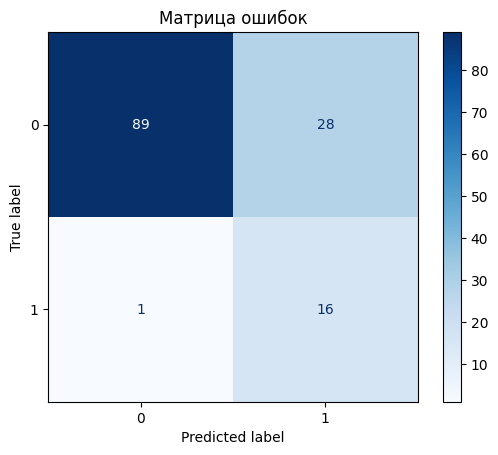


Feature Importances:
                                            feature  importance
37                      Позиция студента в рейтинге    0.395807
9                           Общее количество долгов    0.165465
11                             fromSverdlovskRegion    0.063889
10                                 fromEkaterinburg    0.061876
7                  Полных лет на момент поступления    0.060028
1                            Cумма баллов испытаний    0.055319
8                         Общее количество пересдач    0.055118
31                            Код направления 1: 11    0.044015
0                                         Приоритет    0.036721
18                                          Заочная    0.032332
2                           Балл за инд. достижения    0.029431
5                      Иностранный абитуриент (МОН)    0.000000
3                                          Контракт    0.000000
4                             Нуждается в общежитии    0.000000
13                

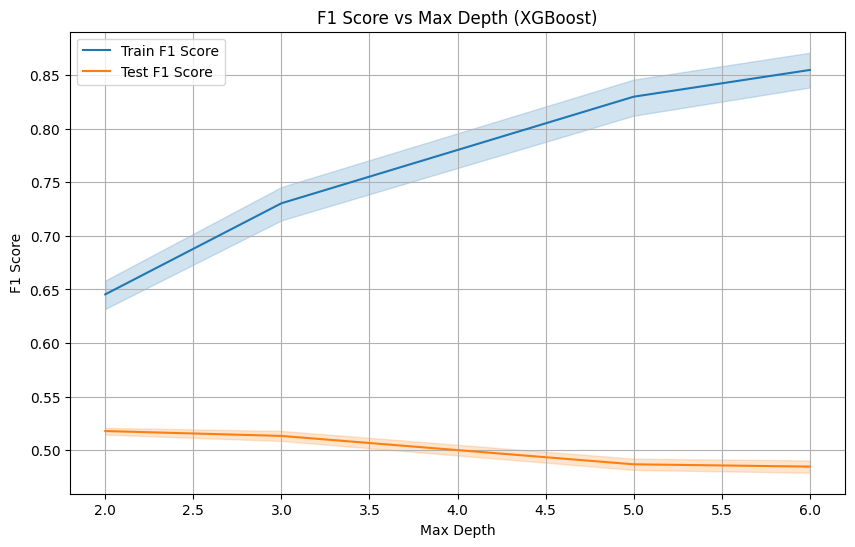

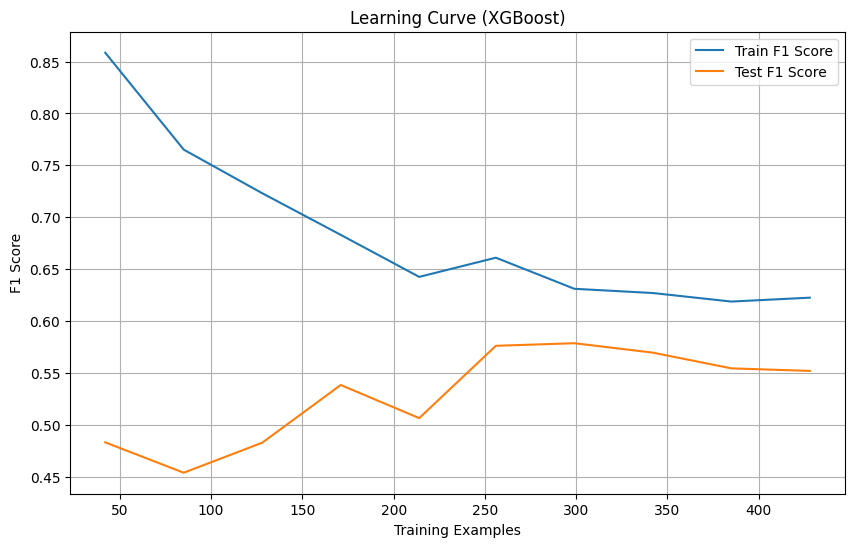

In [6]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import numpy as np
import os

save_dir = 'xgboost/s_magistr'
os.makedirs(save_dir, exist_ok=True)

class_0_count = sum(y_train_s_magistr == 0)
class_1_count = sum(y_train_s_magistr == 1)
scale_pos_weight = class_0_count / class_1_count

print(f"scale_pos_weight = {scale_pos_weight:.2f}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    ))
])

param_grid = [
    {
        'clf': [XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss'
        )],
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [2, 3, 5, 6],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__min_child_weight': [1, 3, 5],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.7, 1.0]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_s_magistr, y_train_s_magistr)

y_pred = grid_search.predict(X_test_s_magistr)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/xgboost_model_s_magistr.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_s_magistr, y_pred))

cm = confusion_matrix(y_test_s_magistr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_xgboost.png"))
plt.show()

importances = best_model.named_steps['clf'].feature_importances_
features = X_train_s_magistr.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth (XGBoost)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_max_depth_xgboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_magistr,
    y=y_train_s_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_xgboost.png"))
plt.show()

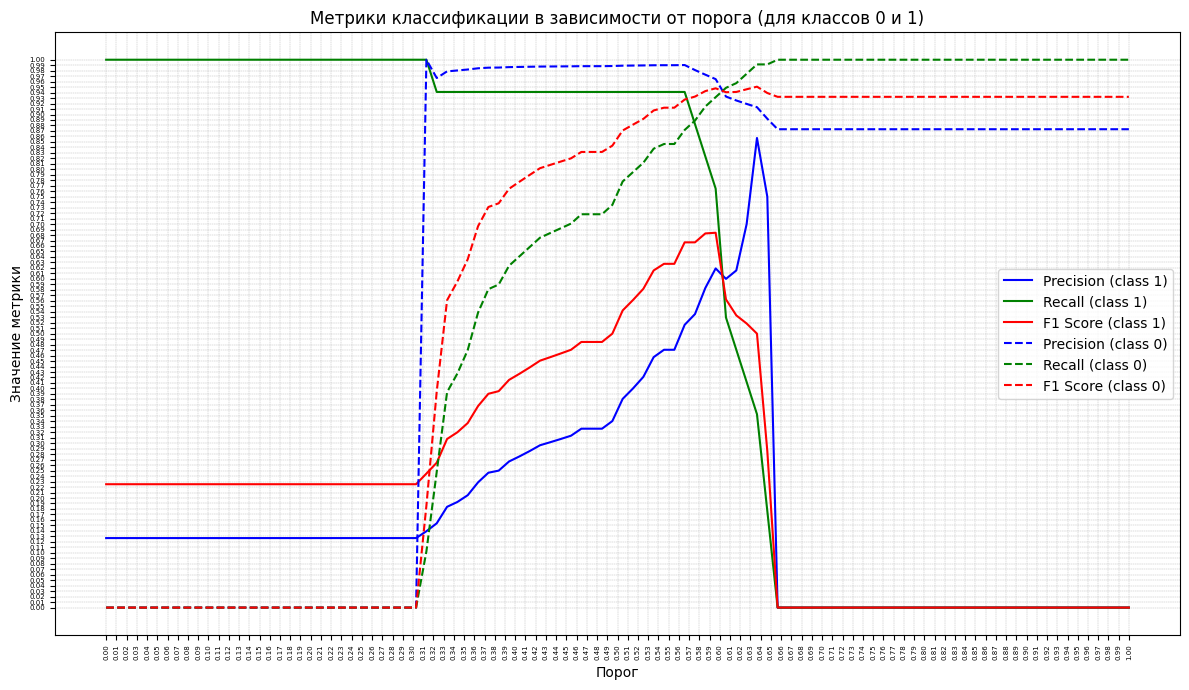

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_magistr, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'xgboost/s_magistr'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_xgboost.png'), dpi=300)
plt.show()

scale_pos_weight = 4.60
Лучшие параметры: {'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__min_child_weight': 5, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Лучшая модель:

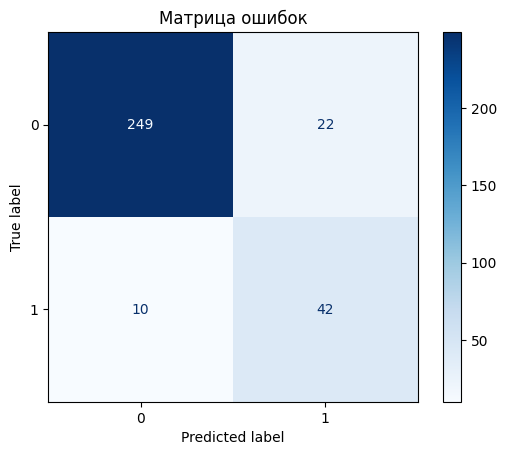


Feature Importances:
                                            feature  importance
10                          Общее количество долгов    0.192128
39                      Позиция студента в рейтинге    0.127241
33                            Код направления 1: 11    0.073206
21                                       Специалист    0.052743
4                                          Контракт    0.040664
8                  Полных лет на момент поступления    0.037017
25                                              СПО    0.033458
38                             Код направления 3: 4    0.033245
9                         Общее количество пересдач    0.031204
24                                 Профильная Школа    0.030429
1                            Cумма баллов испытаний    0.029562
16                                    Целевая квота    0.029326
12                             fromSverdlovskRegion    0.029189
37                             Код направления 3: 3    0.028514
3                 

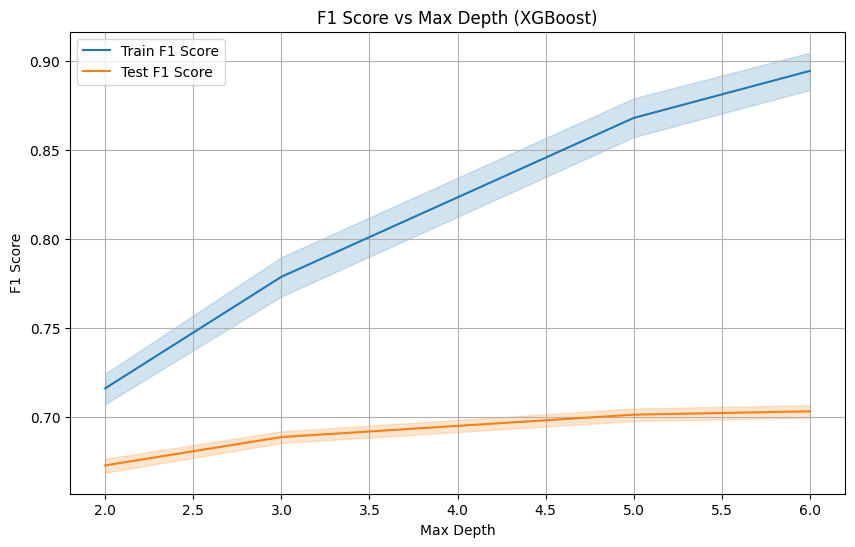

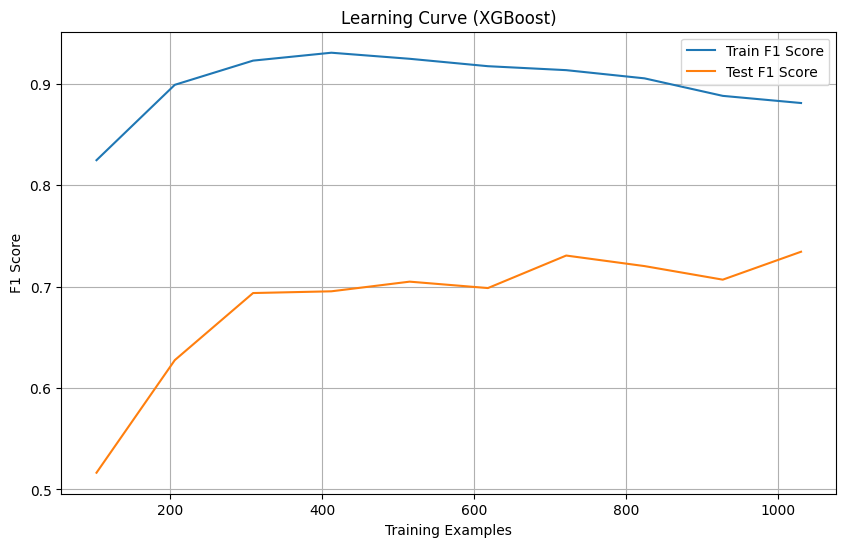

In [8]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import numpy as np
import os

save_dir = 'xgboost/s_bak_spec'
os.makedirs(save_dir, exist_ok=True)

class_0_count = sum(y_train_s_bak_spec == 0)
class_1_count = sum(y_train_s_bak_spec == 1)
scale_pos_weight = class_0_count / class_1_count

print(f"scale_pos_weight = {scale_pos_weight:.2f}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    ))
])

param_grid = [
    {
        'clf': [XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss'
        )],
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [2, 3, 5, 6],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__min_child_weight': [1, 3, 5],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.7, 1.0]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_s_bak_spec, y_train_s_bak_spec)

y_pred = grid_search.predict(X_test_s_bak_spec)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/xgboost_model_s_bak_spec.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_s_bak_spec, y_pred))

cm = confusion_matrix(y_test_s_bak_spec, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_xgboost.png"))
plt.show()

importances = best_model.named_steps['clf'].feature_importances_
features = X_train_s_bak_spec.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth (XGBoost)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_max_depth_xgboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_s_bak_spec,
    y=y_train_s_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_xgboost.png"))
plt.show()

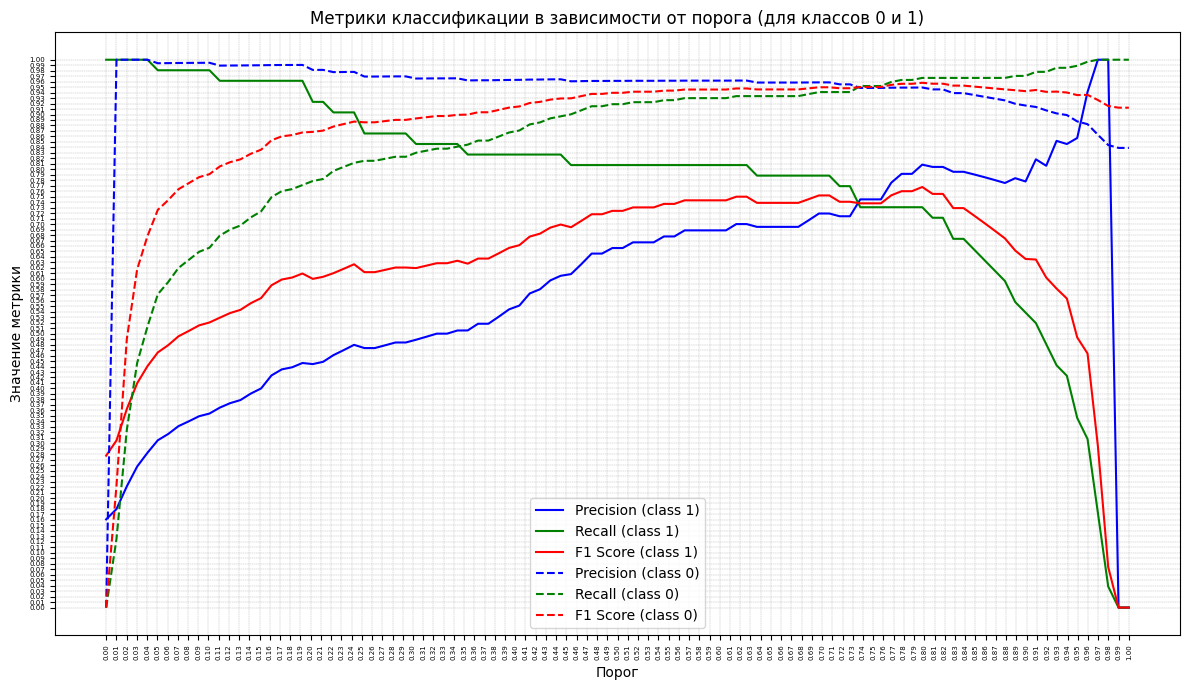

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_s_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_s_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'xgboost/s_bak_spec'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_xgboost.png'), dpi=300)
plt.show()

scale_pos_weight = 5.62
Лучшие параметры: {'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.2, 'clf__max_depth': 3, 'clf__min_child_weight': 5, 'clf__n_estimators': 50, 'clf__subsample': 1.0}
Лучшая модель: 

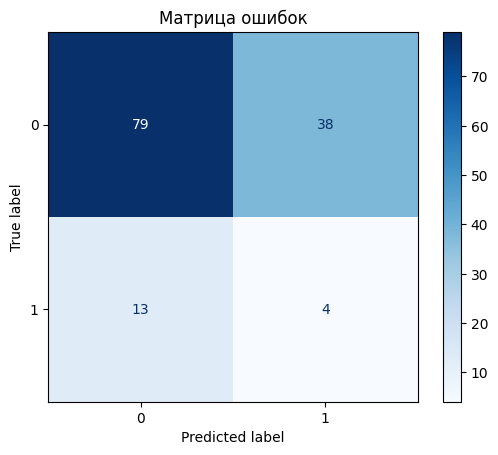


Feature Importances:
                                            feature  importance
4                             Нуждается в общежитии    0.129798
6                                               Пол    0.097220
34                             Код направления 3: 4    0.085470
10                          Human Development Index    0.079095
2                           Балл за инд. достижения    0.076557
8                                  fromEkaterinburg    0.072550
3                                          Контракт    0.071150
1                            Cумма баллов испытаний    0.064717
7                  Полных лет на момент поступления    0.064675
9                              fromSverdlovskRegion    0.062154
29                            Код направления 1: 11    0.052102
30                            Код направления 1: 27    0.049901
0                                         Приоритет    0.034861
28                            Код направления 1: 10    0.032794
32                

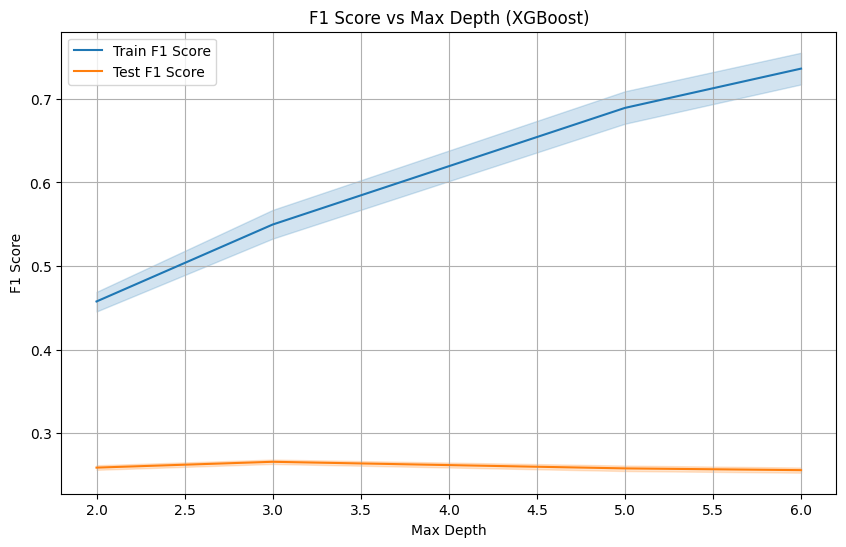

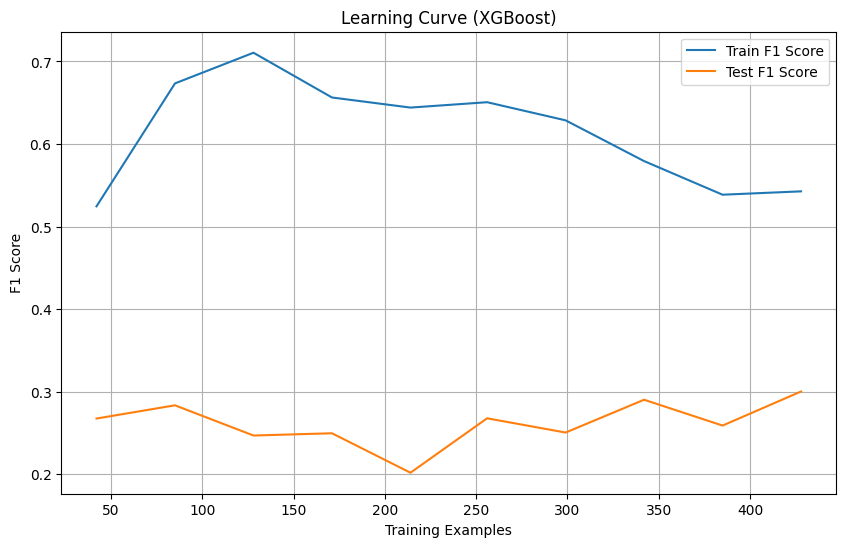

In [10]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import numpy as np
import os

save_dir = 'xgboost/c1_magistr'
os.makedirs(save_dir, exist_ok=True)

class_0_count = sum(y_train_c1_magistr == 0)
class_1_count = sum(y_train_c1_magistr == 1)
scale_pos_weight = class_0_count / class_1_count

print(f"scale_pos_weight = {scale_pos_weight:.2f}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    ))
])

param_grid = [
    {
        'clf': [XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss'
        )],
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [2, 3, 5, 6],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__min_child_weight': [1, 3, 5],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.7, 1.0]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_c1_magistr, y_train_c1_magistr)

y_pred = grid_search.predict(X_test_c1_magistr)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/xgboost_model_c1_magistr.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_magistr, y_pred))

cm = confusion_matrix(y_test_c1_magistr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_xgboost.png"))
plt.show()

importances = best_model.named_steps['clf'].feature_importances_
features = X_train_c1_magistr.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth (XGBoost)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_max_depth_xgboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_c1_magistr,
    y=y_train_c1_magistr,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_xgboost.png"))
plt.show()

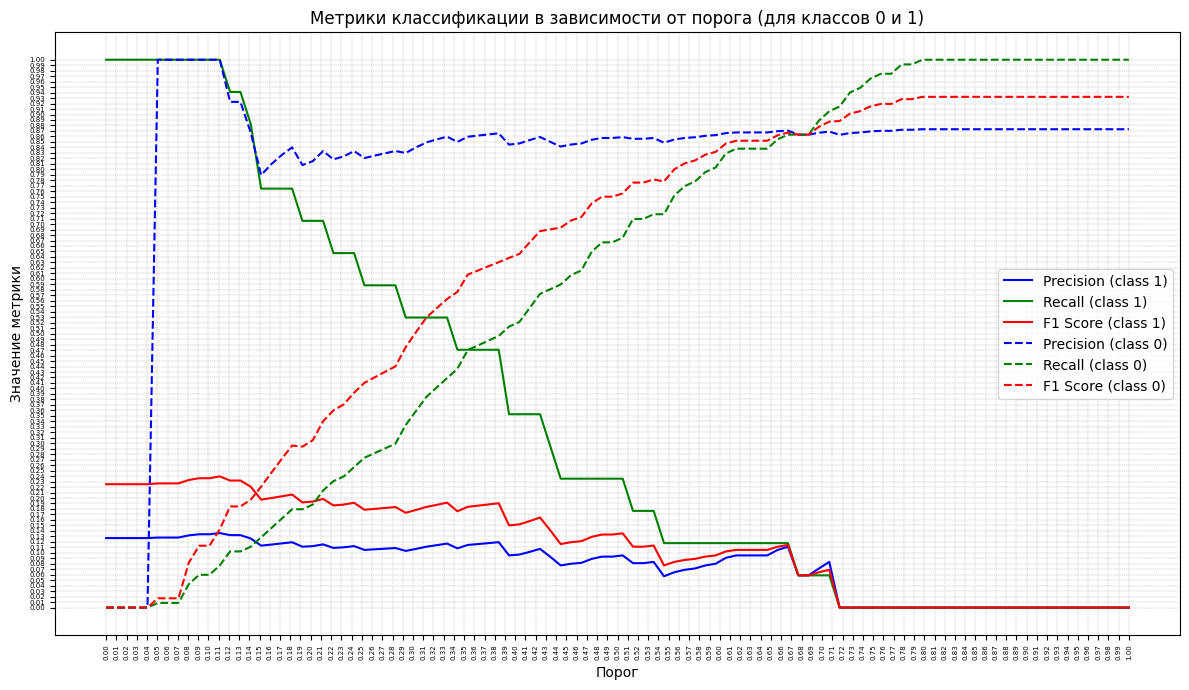

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_c1_magistr)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_magistr, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'xgboost/c1_magistr'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_xgboost.png'), dpi=300)
plt.show()

scale_pos_weight = 4.60
Лучшие параметры: {'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_child_weight': 5, 'clf__n_estimators': 150, 'clf__subsample': 0.8}
Лучшая модель

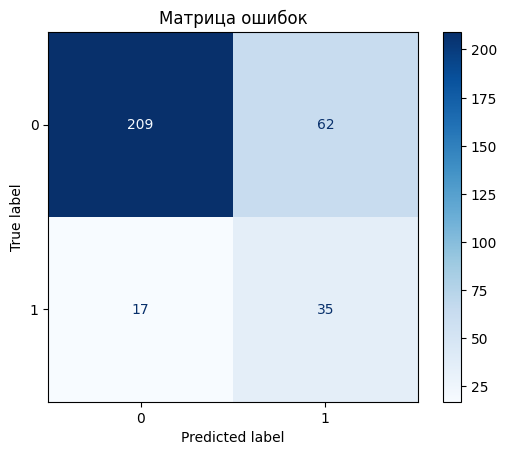


Feature Importances:
                                            feature  importance
8                  Полных лет на момент поступления    0.110053
3                           Балл за инд. достижения    0.069605
17                                          Заочная    0.065882
19                                       Специалист    0.054568
32                            Код направления 1: 27    0.054175
4                                          Контракт    0.053292
1                            Cумма баллов испытаний    0.049347
11                          Human Development Index    0.046911
14                                    Целевая квота    0.041713
18                                     Очно-заочная    0.041326
12                                     Особая квота    0.040563
7                                               Пол    0.032357
24                                  Боевые действия    0.030458
31                            Код направления 1: 11    0.030162
22                

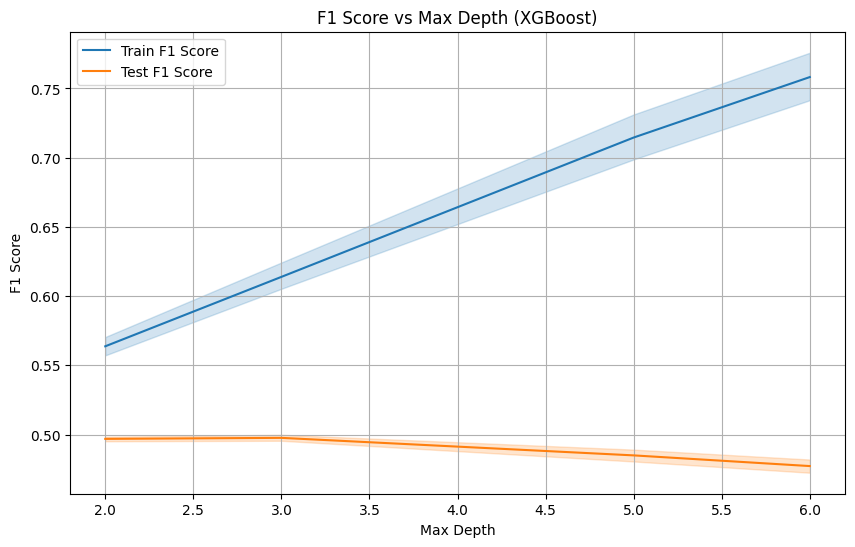

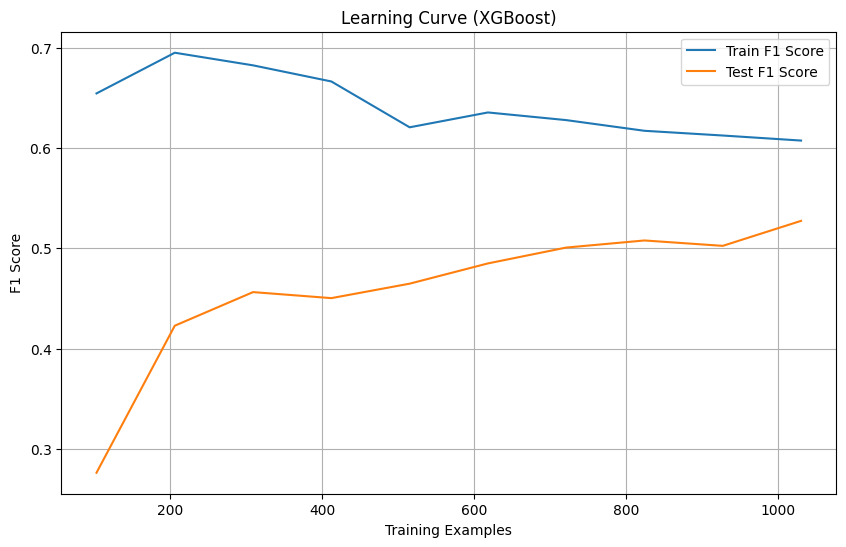

In [12]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import numpy as np
import os

save_dir = 'xgboost/c1_bak_spec'
os.makedirs(save_dir, exist_ok=True)

class_0_count = sum(y_train_c1_bak_spec == 0)
class_1_count = sum(y_train_c1_bak_spec == 1)
scale_pos_weight = class_0_count / class_1_count

print(f"scale_pos_weight = {scale_pos_weight:.2f}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    ))
])

param_grid = [
    {
        'clf': [XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss'
        )],
        'clf__n_estimators': [50, 100, 150],
        'clf__max_depth': [2, 3, 5, 6],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__min_child_weight': [1, 3, 5],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.7, 1.0]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_c1_bak_spec, y_train_c1_bak_spec)

y_pred = grid_search.predict(X_test_c1_bak_spec)
best_model = grid_search.best_estimator_
joblib.dump(best_model, '../../data/models/xgboost_model_c1_bak_spec.joblib')

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая модель:", best_model)
print("\nОтчёт классификации:\n", classification_report(y_test_c1_bak_spec, y_pred))

cm = confusion_matrix(y_test_c1_bak_spec, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(cmap="Blues")
plt.title("Матрица ошибок")
plt.savefig(os.path.join(save_dir, "confusion_matrix_xgboost.png"))
plt.show()

importances = best_model.named_steps['clf'].feature_importances_
features = X_train_c1_bak_spec.columns
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

results = pd.DataFrame(grid_search.cv_results_)
results_filtered = results[[
    'param_clf__max_depth',
    'mean_train_score',
    'mean_test_score'
]].copy()
results_filtered['param_clf__max_depth'] = pd.to_numeric(results_filtered['param_clf__max_depth'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_train_score', label='Train F1 Score')
sns.lineplot(data=results_filtered, x='param_clf__max_depth', y='mean_test_score', label='Test F1 Score')
plt.title('F1 Score vs Max Depth (XGBoost)')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "f1_vs_max_depth_xgboost.png"))
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train_c1_bak_spec,
    y=y_train_c1_bak_spec,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Score')
plt.plot(train_sizes, test_scores_mean, label='Test F1 Score')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, "learning_curve_xgboost.png"))
plt.show()

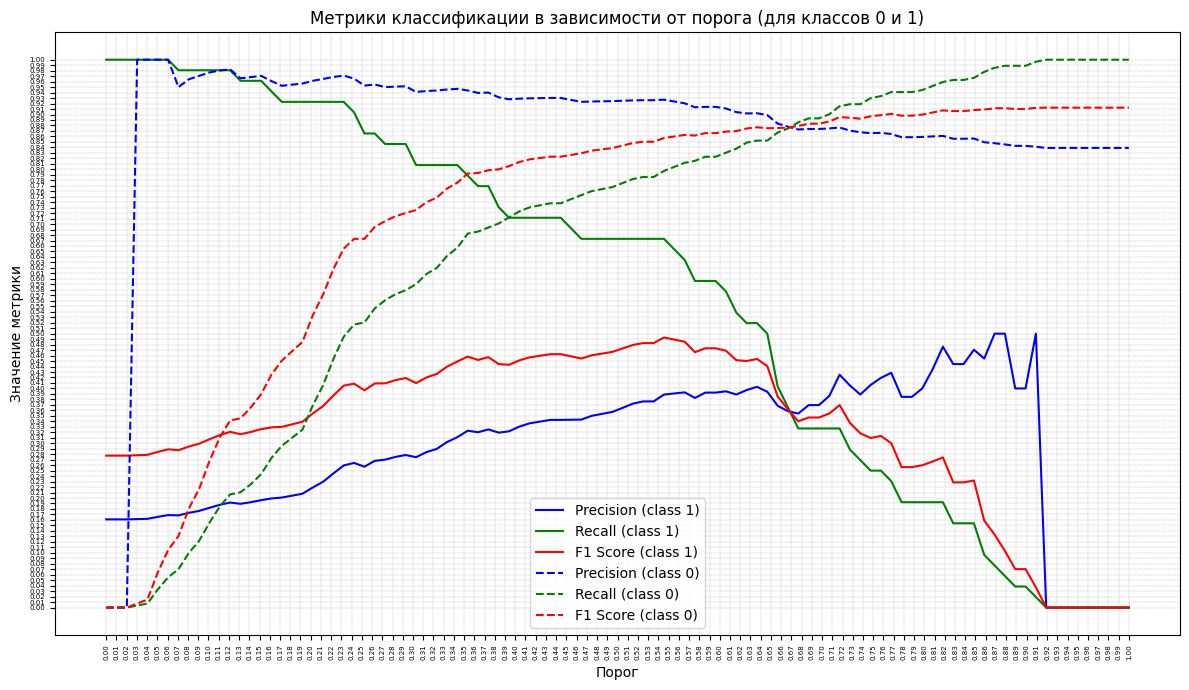

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

y_probs = grid_search.predict_proba(X_test_c1_bak_spec)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions_1, recalls_1, f1_scores_1 = [], [], []
precisions_0, recalls_0, f1_scores_0 = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)

    precisions_1.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    recalls_1.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))
    f1_scores_1.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=1, zero_division=0))

    precisions_0.append(precision_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    recalls_0.append(recall_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))
    f1_scores_0.append(f1_score(y_test_c1_bak_spec, y_pred_thresh, pos_label=0, zero_division=0))

save_path = 'xgboost/c1_bak_spec'

plt.figure(figsize=(12, 7))

plt.plot(thresholds, precisions_1, label='Precision (class 1)', color='blue')
plt.plot(thresholds, recalls_1, label='Recall (class 1)', color='green')
plt.plot(thresholds, f1_scores_1, label='F1 Score (class 1)', color='red')

plt.plot(thresholds, precisions_0, '--', label='Precision (class 0)', color='blue')
plt.plot(thresholds, recalls_0, '--', label='Recall (class 0)', color='green')
plt.plot(thresholds, f1_scores_0, '--', label='F1 Score (class 0)', color='red')

plt.xticks(np.arange(0, 1.01, 0.01), rotation=90, fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.01), fontsize=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

plt.xlabel('Порог')
plt.ylabel('Значение метрики')
plt.title('Метрики классификации в зависимости от порога (для классов 0 и 1)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_path, 'metrics_vs_threshold_xgboost.png'), dpi=300)
plt.show()